# Report: Ex0 - MNIST in the cloud

## Tore Aadland

First lets load required modules and seed the random number generators to make results reproducible:

In [1]:
import datetime
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, InputLayer
from keras.datasets import mnist
from keras.utils import to_categorical, plot_model
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l2
from keras.callbacks import TensorBoard
from IPython.display import SVG
import numpy as np
import os
import random as rn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import time

rn.seed(42)
np.random.seed(42)

C:\Users\Tore\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load training data:

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Seems ok.

Scale and cast data:

In [3]:
# Cast:
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Scale:
scaler = StandardScaler(with_mean=True, with_std=True)
train_images = scaler.fit_transform(train_images.reshape((60000, 784))).reshape((60000, 28, 28))
test_images = scaler.transform(test_images.reshape((10000, 784))).reshape((10000, 28, 28))

Get some validation data:

In [4]:
from sklearn.model_selection import train_test_split
validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

Checking that training, validation and test dataset is shufled.

In [5]:
print(train_labels[0:20])
print(validation_labels[0:20])
print(test_labels[0:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[8 4 3 1 2 9 0 5 8 7 7 7 5 7 6 1 1 3 2 7]
[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5]


Plotting a few of the training images:

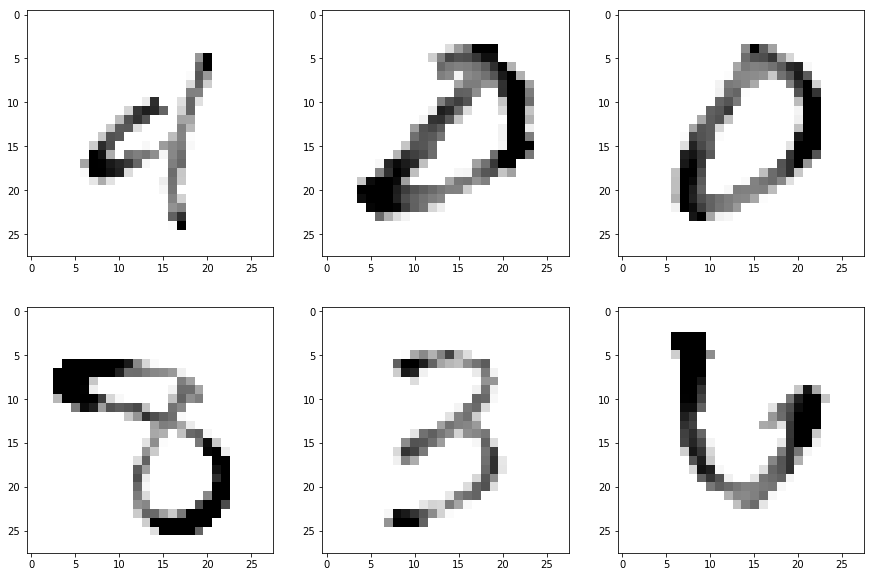

In [6]:
plt.figure(figsize=(15,10))
for j, i in enumerate(np.random.choice(len(train_images), 6)):
    plt.subplot(2, 3, j+1)
    plt.imshow(train_images[i], cmap="Greys", vmin=0, vmax=2)
plt.show()

Lets define a helper function that fits, visualizes and stores trained models and which generates the data requested in the exercise text:

In [29]:
from collections import namedtuple
ModelPerformance = namedtuple('ModelPerformance', 
        ['name', 'loss', 'val_loss', 'acc', 'val_acc', 'final_loss', 'final_accuracy', 'time'])

d_mp = {}
def fit_and_save_model(name, model, X_train, y_train, X_validation, y_validation,
                       epochs = 10, batch_size=64, validation_split = 1.0/12, eval_batch_size=128):
    required_folders = './output/{}/logs/'.format(name)
    if not os.path.exists(required_folders):
        os.makedirs(required_folders)

    # Validation data is not shuffled! This is probably a problem!
    tensorboard = TensorBoard('./output/{}/logs/{}'.format(name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")))
    
    start_time = time.time()
    history = model.fit(X_train, to_categorical(y_train), 
                        validation_data=(validation_images, to_categorical(validation_labels)), 
                        epochs=epochs,
                        batch_size=batch_size, 
                        verbose=0, 
                        callbacks=[tensorboard])
    end_time = time.time()
    score = model.evaluate(X_validation, to_categorical(y_validation), verbose=0)
    

        
    model.save('./output/{}/{}.h5'.format(name, name))
    with open("./output/{}/{}.json".format(name, name), 'w+') as f:
        f.write(model.to_json())
    
    print("I train a model with the following shape:")
    plot_model(model, 
           to_file='./output/{}/model_visualization_{}.png'.format(name,name),
           show_shapes=True,
           show_layer_names=True)
    display(SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg')))
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig('./output/{}/performance_{}.png'.format(name,name))
    plt.show()
    
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    d_mp[name] = ModelPerformance(name, 
                                  history.history['loss'], 
                                  history.history['val_loss'],
                                  history.history['acc'], 
                                  history.history['val_acc'],
                                  score[0], 
                                  score[1], 
                                  end_time-start_time)
    
    with open("./output/{}/{}.score".format(name, name), 'w+') as f:
        f.write(summary)
    

    print("It has the following confusion matrix:")
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    
    y_true = y_validation.ravel()
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.savefig('./output/{}/confusion_matrix_{}.png'.format(name,name))
    plt.title("Confusion matrix - {}".format(name))
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()
    
    print("These are examples of misclassified features:")
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.suptitle("Misclassified images - Model {}".format(name))
    poss_indexes = np.argwhere(y_predicted-y_true != 0)
    indexes = poss_indexes[np.random.choice(len(poss_indexes), 6)]
    
    for i, index in enumerate(indexes.ravel()):
        plt.subplot(2, 3, i+1)
        plt.imshow(X_validation[index], cmap="Greys", vmin=0, vmax=2)
        plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
    plt.savefig('./output/{}/misclassified_features_{}.png'.format(name,name))
    plt.show()

Now create and train a simple sequential model without any regularization:

TODO: Comment on the use of softmax as the final layers activation function.

I train a model with the following shape:


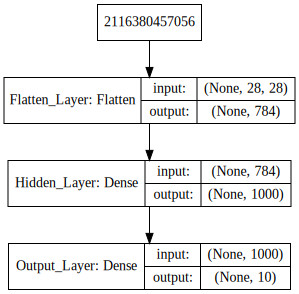

It has the following training history:


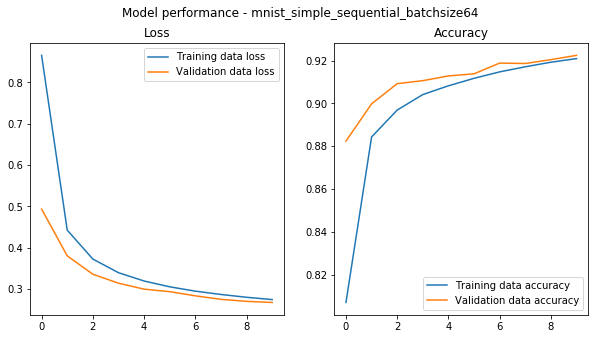

It has the following performance:
Validation loss: 0.2679136775493622
Validation accuracy: 0.9224
Training time: 47.38315749168396
It has the following confusion matrix:


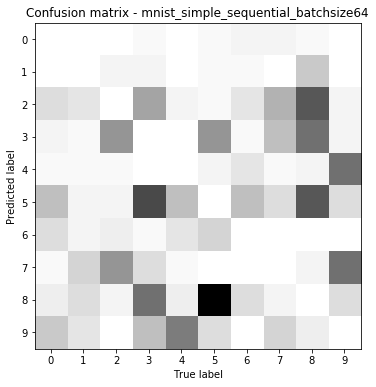

These are examples of misclassified features:


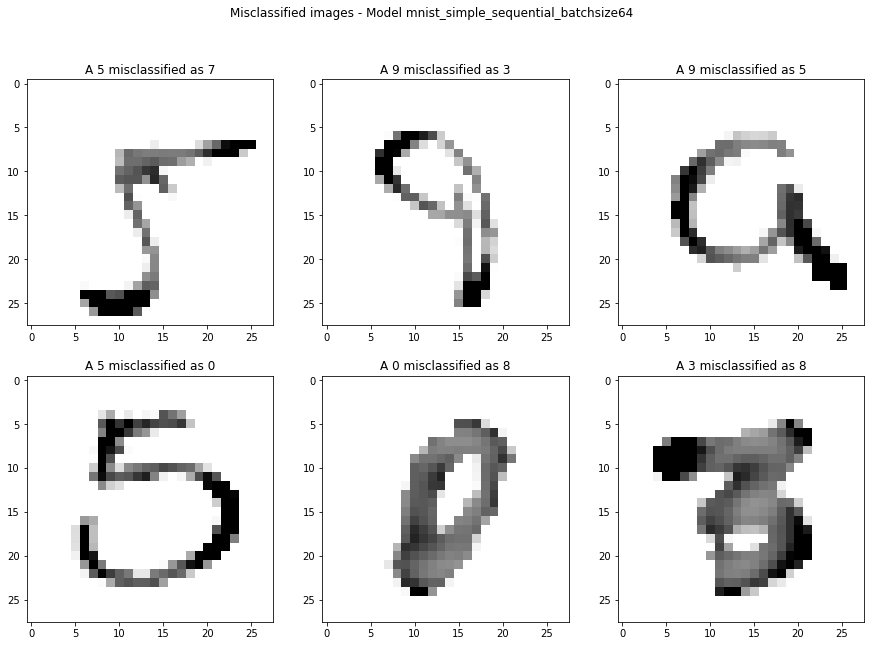

In [30]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28), name="Flatten_Layer"))
simple_sequential.add(Dense(1000, activation='sigmoid', name="Hidden_Layer"))
simple_sequential.add(Dense(10, activation='softmax', name="Output_Layer"))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential_batchsize64", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels,
                   epochs = 10, batch_size=64)

Now create and train a simple sequential model without any regularization using a batch size of 128.

I train a model with the following shape:


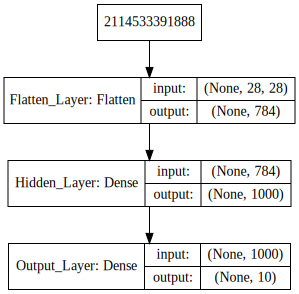

It has the following training history:


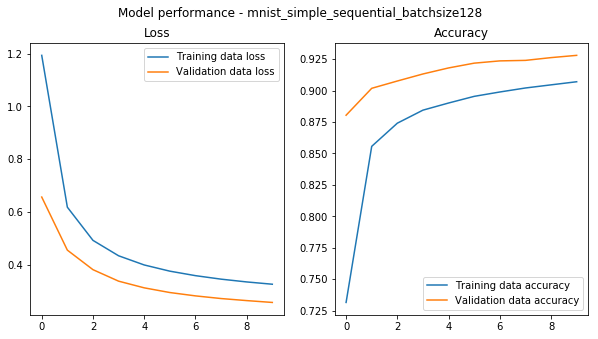

It has the following performance:
Validation loss: 0.3062775377750397
Validation accuracy: 0.9128
Training time: 24.36358880996704
It has the following confusion matrix:


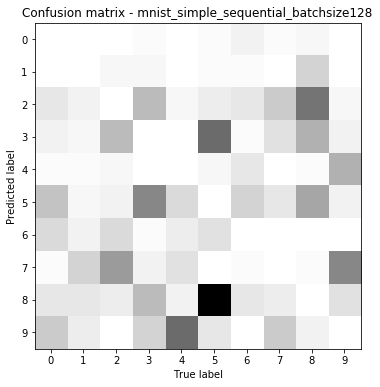

These are examples of misclassified features:


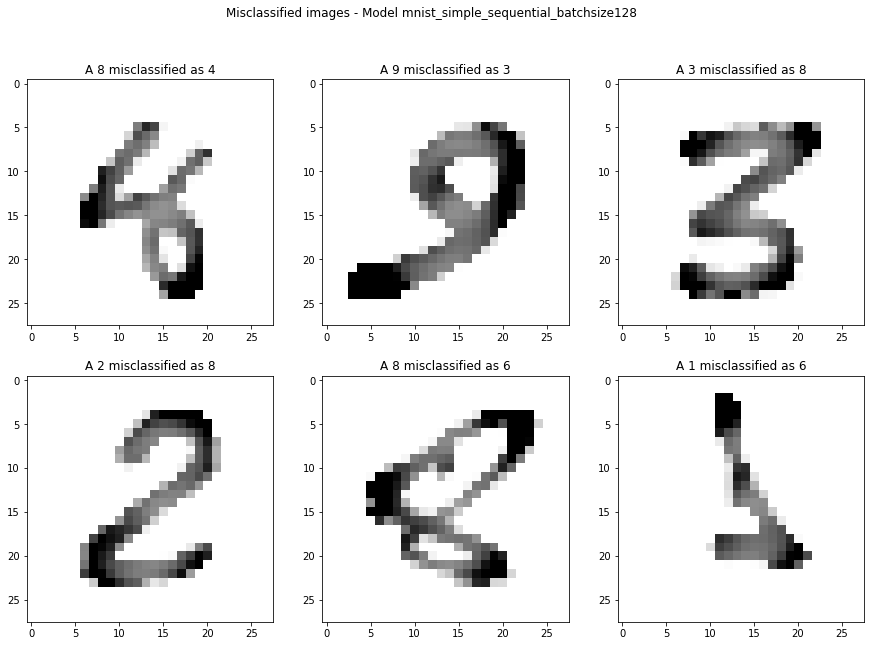

In [14]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28), name="Flatten_Layer"))
simple_sequential.add(Dense(1000, activation='sigmoid', name="Hidden_Layer"))
simple_sequential.add(Dense(10, activation='softmax', name="Output_Layer"))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential_batchsize128", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels,
                   epochs = 10, batch_size=128)

We see that ... TODO ...

Lets try to recreate LeNet-5. I follow the summary of LeNet-5:
![](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)
From: https://engmrk.com/lenet-5-a-classic-cnn-architecture/

I train a model with the following shape:


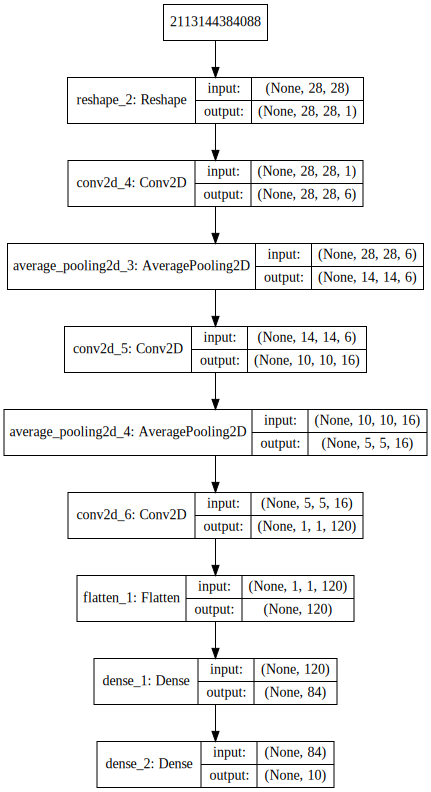

It has the following training history:


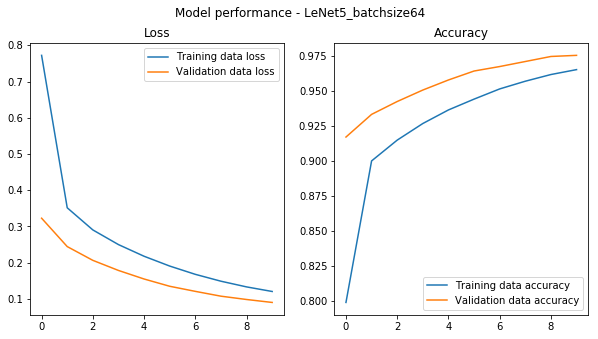

It has the following performance:
Validation loss: 0.10312453949451447
Validation accuracy: 0.9708
Training time: 349.22062492370605
It has the following confusion matrix:


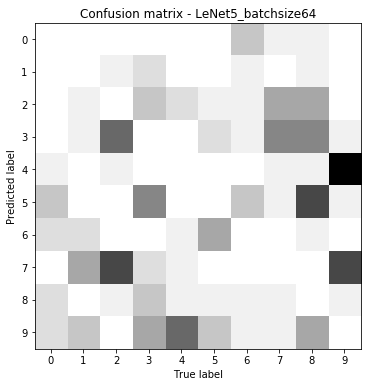

These are examples of misclassified features:


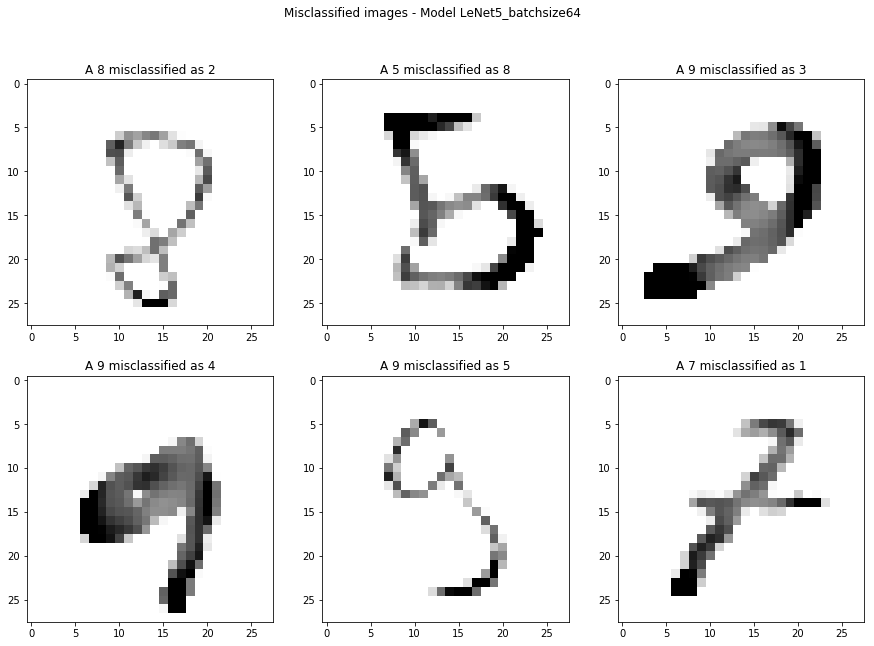

In [9]:
simple_convolutional = Sequential()
simple_convolutional.add(Reshape((28,28, 1), input_shape=(28,28)))
simple_convolutional.add(Conv2D(6, 
                 kernel_size=5,
                 activation="tanh",
                 padding="same"))
simple_convolutional.add(AveragePooling2D(pool_size=(2,2)))
simple_convolutional.add(Conv2D(16, 
                 kernel_size=5,
                 activation="tanh"))
simple_convolutional.add(AveragePooling2D(pool_size=(2,2)))
simple_convolutional.add(Conv2D(120, 
                 kernel_size=5,
                 activation="tanh"))
simple_convolutional.add(Flatten())
simple_convolutional.add(Dense(84, activation='tanh'))
simple_convolutional.add(Dense(10, activation='softmax'))
simple_convolutional.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("LeNet5_batchsize64", simple_convolutional,
                train_images, train_labels, validation_images, validation_labels,
                  epochs = 10, batch_size=64)

I train a model with the following shape:


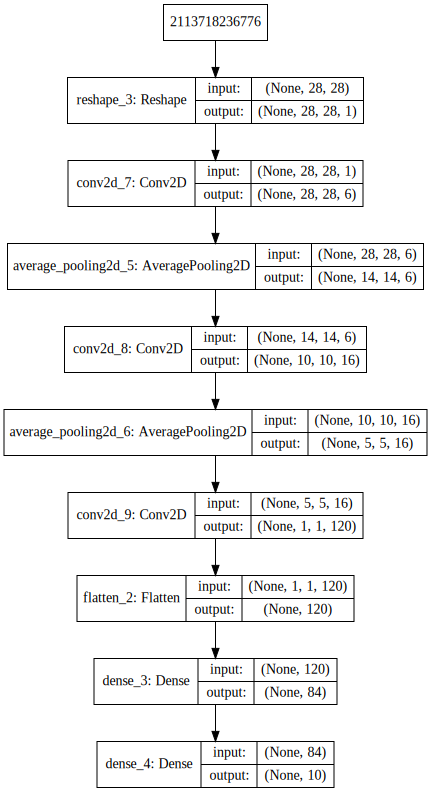

It has the following training history:


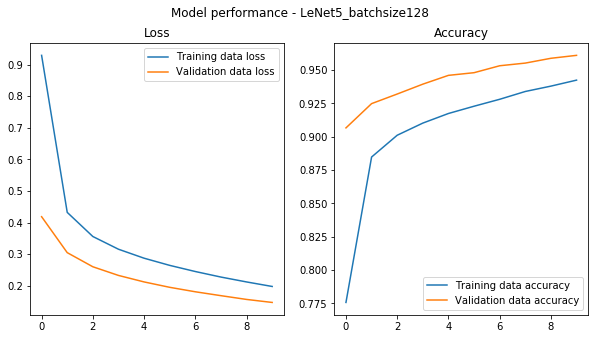

It has the following performance:
Validation loss: 0.17527330151796341
Validation accuracy: 0.9484
Training time: 47.2912437915802
It has the following confusion matrix:


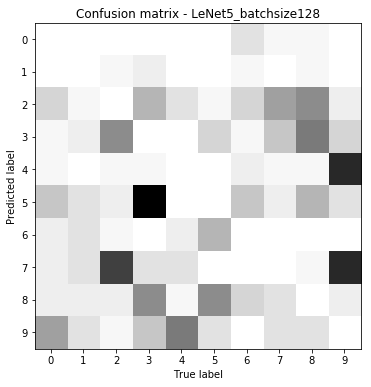

These are examples of misclassified features:


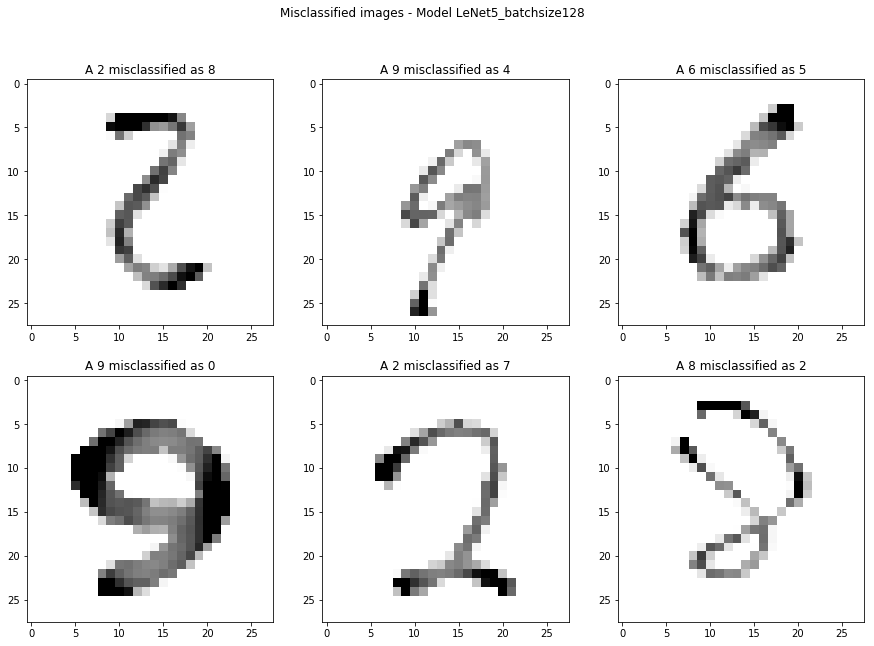

In [10]:
simple_convolutional = Sequential()
simple_convolutional.add(Reshape((28,28, 1), input_shape=(28,28)))
simple_convolutional.add(Conv2D(6, 
                 kernel_size=5,
                 activation="tanh",
                 padding="same"))
simple_convolutional.add(AveragePooling2D(pool_size=(2,2)))
simple_convolutional.add(Conv2D(16, 
                 kernel_size=5,
                 activation="tanh"))
simple_convolutional.add(AveragePooling2D(pool_size=(2,2)))
simple_convolutional.add(Conv2D(120, 
                 kernel_size=5,
                 activation="tanh"))
simple_convolutional.add(Flatten())
simple_convolutional.add(Dense(84, activation='tanh'))
simple_convolutional.add(Dense(10, activation='softmax'))
simple_convolutional.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("LeNet5_batchsize128", simple_convolutional,
                train_images, train_labels, validation_images, validation_labels,
                  epochs = 10, batch_size=128)

In [38]:
# Tasks: Experiment with different hyperparameter settings (e.g. learning rate, early stopping, batch sizes, etc)
# and observe their effects on training time, overfitting, and final accuracy.
# See if L2 regularisation has effect on network using relu activation function.
# Compare contrast with relu + dropout.

In [19]:
def compare_performance_of(modelsToBeEvaluated):
    #modelsToBeEvaluated = [n1, n2]
    plt.figure(figsize=(16,8))
    plt.subplot(1, 2, 1)

    for name in modelsToBeEvaluated:
        #plt.plot(d_mp[name].loss, label='{} training data loss'.format(name))
        plt.plot(d_mp[name].val_loss, label='{} validation data loss'.format(name))
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    for name in modelsToBeEvaluated:
        #plt.plot(d_mp[name].acc, label='{} training data accuracy'.format(name))
        plt.plot(d_mp[name].val_acc, label='{} validation data accuracy'.format(name))
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Performance of the different models on validation data")
    plt.show()

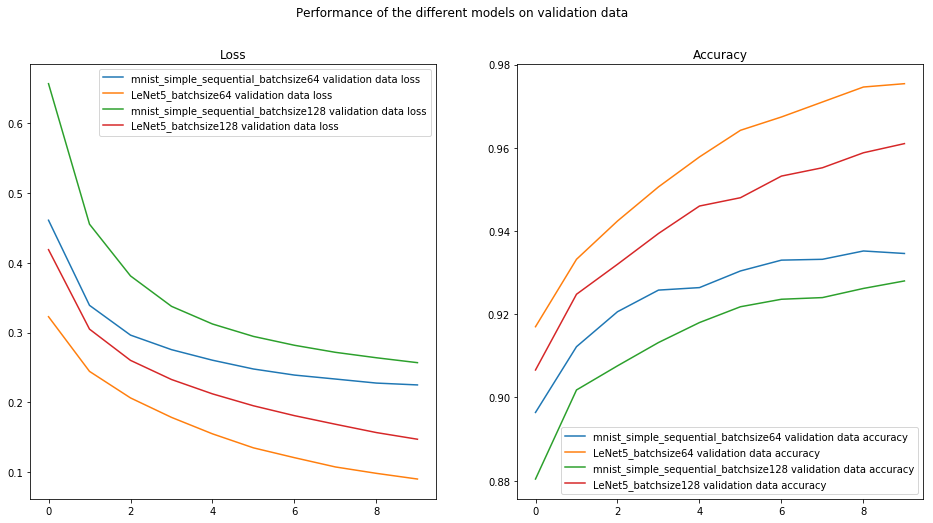

In [20]:
compare_performance_of(["mnist_simple_sequential_batchsize64", "LeNet5_batchsize64", "mnist_simple_sequential_batchsize128", "LeNet5_batchsize128"])

## Exploring the effect of the activation function on a L2 regularizer:

I train a model with the following shape:


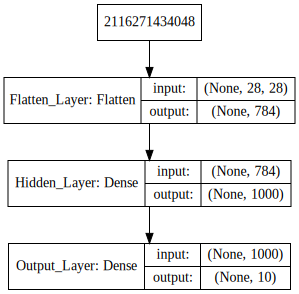

It has the following training history:


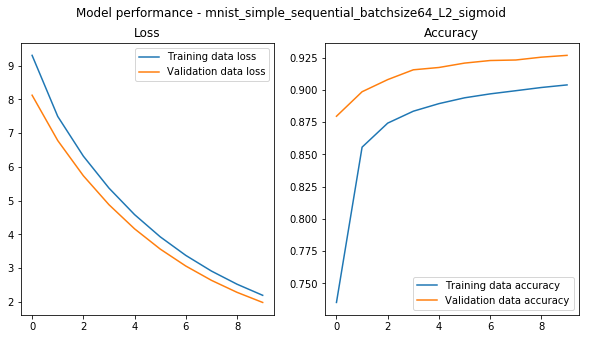

It has the following performance:
Validation loss: 2.0378813339233397
Validation accuracy: 0.91
Training time: 23.5284321308136
It has the following confusion matrix:


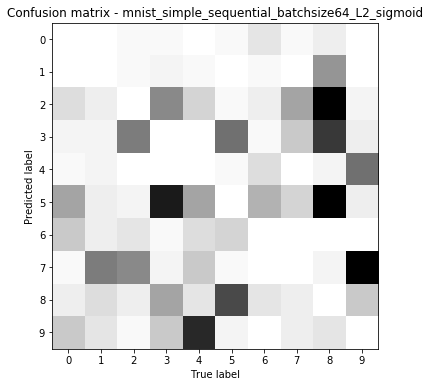

These are examples of misclassified features:


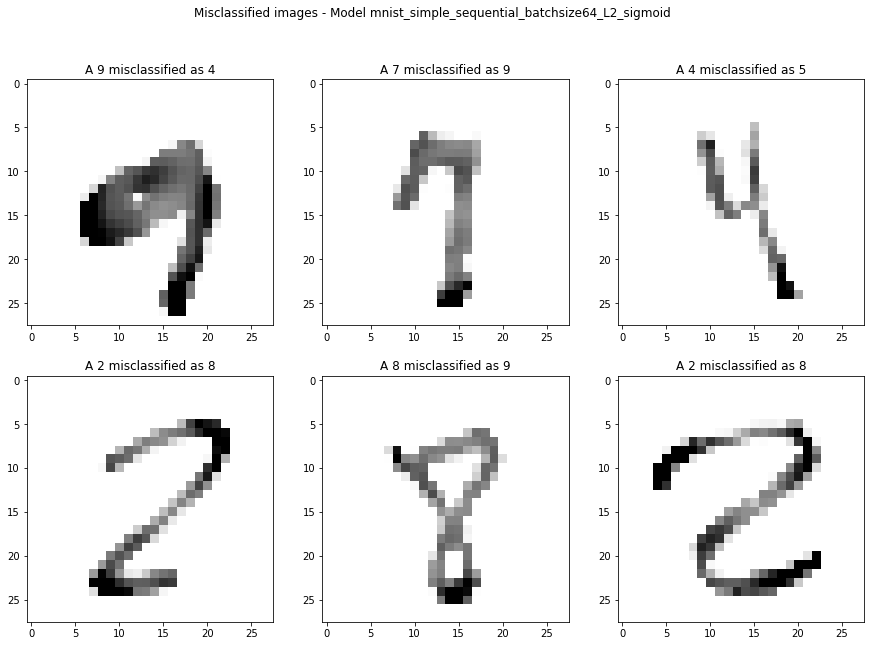

In [24]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28), name="Flatten_Layer"))
simple_sequential.add(Dense(1000, activation='sigmoid', name="Hidden_Layer", kernel_regularizer=l2(0.01)))
simple_sequential.add(Dense(10, activation='softmax', name="Output_Layer"))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential_batchsize64_L2_sigmoid", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels,
                   epochs = 10, batch_size=128)

I train a model with the following shape:


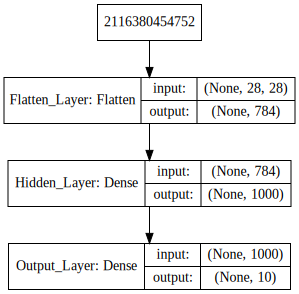

It has the following training history:


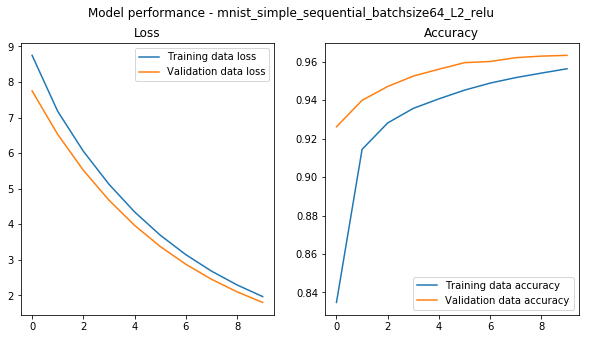

It has the following performance:
Validation loss: 1.8280780540466308
Validation accuracy: 0.9522
Training time: 26.535576820373535
It has the following confusion matrix:


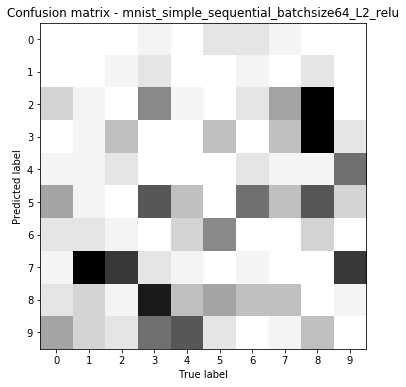

These are examples of misclassified features:


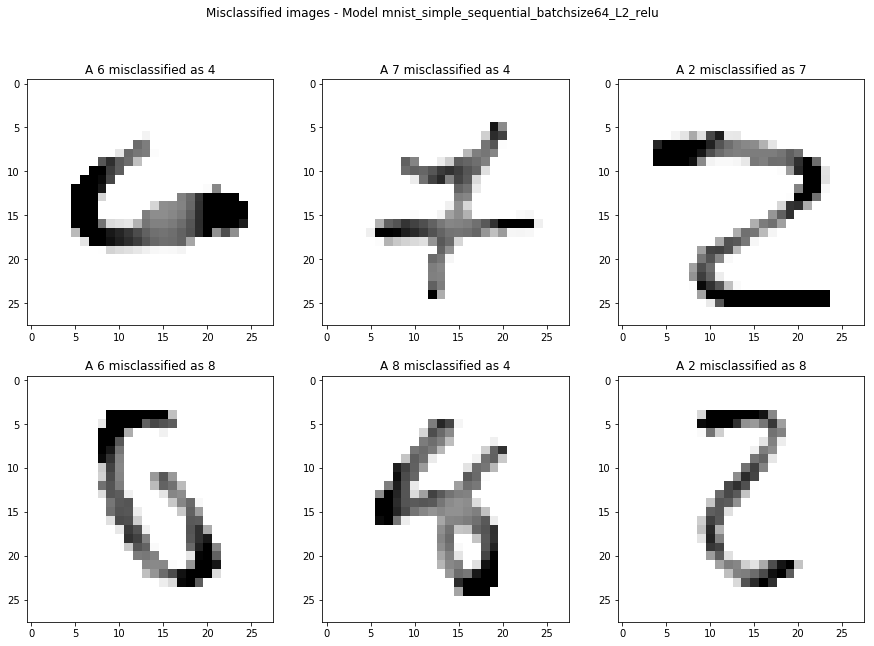

In [25]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28), name="Flatten_Layer"))
simple_sequential.add(Dense(1000, activation='relu', name="Hidden_Layer", kernel_regularizer=l2(0.01)))
simple_sequential.add(Dense(10, activation='softmax', name="Output_Layer"))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential_batchsize64_L2_relu", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels,
                   epochs = 10, batch_size=128)

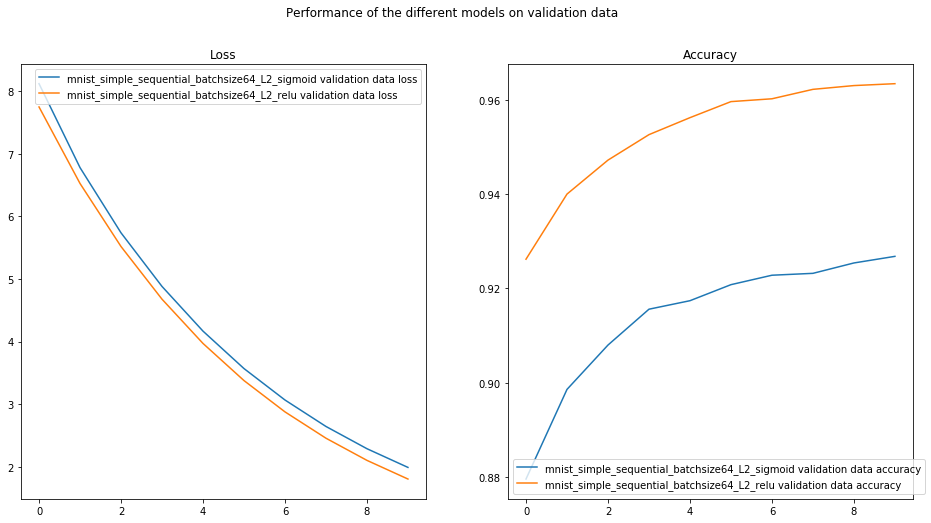

In [26]:
compare_performance_of(["mnist_simple_sequential_batchsize64_L2_sigmoid", "mnist_simple_sequential_batchsize64_L2_relu"])

# Conclusion:
The effect of the L2 regularizer is much stronger on the neural network with a sigmoid activation function.